In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepmass import spherical_deepmass as sdm

/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


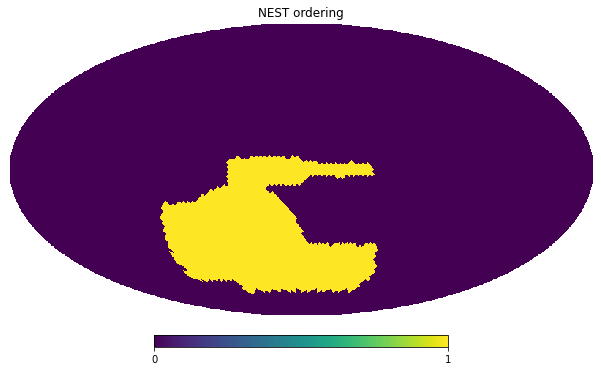

In [2]:
nside = 32
npix = hp.nside2npix(nside=nside)
batch_size = 10
learning_rate = 1e-5


###Importing mask        
mask = hp.read_map('DESY3_sky_mask.fits') # It's in RING ordering
mask = np.ceil(hp.ud_grade(mask,nside))
mask = hp.reorder(mask,r2n=True)

hp.mollview(mask,title='NEST ordering',nest=True)

In [3]:
def power_spectrum(l, A, mu, sigma):
    """Generate power spectrum from gaussian distribution.
    Input:
    l      angular location
    A      amplitude
    simga  standard deviation
    mu     mean
    """
    return A*np.exp((-1/2)*(l-mu)**2/(sigma**2))

indices = np.arange(hp.nside2npix(nside)) # indices of relevant pixels [0, pixels)
l = np.arange(nside)

c_l = power_spectrum(l, 1, 5,25)

n=1000 # number of sets 
gaussian_maps = np.array([hp.reorder(hp.synfast(c_l, nside),inp='RING',out='NESTED') for i in range(n)])
#rescale - ensure all values are between 0-1 with average on 0.5.
factor = 20*np.max(np.abs(gaussian_maps))*np.ones(shape=gaussian_maps.shape)
mean = 0.5 #because of last layer having softmax activation, model can't replicate -ve values.
gaussian_maps  = gaussian_maps/factor+mean*np.ones(shape=gaussian_maps.shape)

/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


We build the network with an input shape and print out a summary.

In [4]:
tf.keras.backend.clear_session()

unet_instance = sdm.HealpyUNet(nside, indices, learning_rate, mask, mean, n_neighbors=20)
unet_model = unet_instance.model()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12288, 1)]   0                                            
__________________________________________________________________________________________________
chebyshev (Chebyshev)           (None, 12288, 16)    208         input_1[0][0]                    
__________________________________________________________________________________________________
healpy_pool (HealpyPool)        (None, 3072, 16)     0           chebyshev[0][0]                  
__________________________________________________________________________________________________
chebyshev_1 (Chebyshev)         (None, 3072, 32)     5216        healpy_pool[0][0]                
_______________________________________________________________________________________

We create a dataset for the training with a channel dimension (not strictly necessary if you use the TF routines 
for training) and labels.

We run the model.

In [5]:
tot_train_loss=[]
tot_val_loss=[]

In [11]:
import time

epoch=60
p=0.95 #train-test split

for k in range(epoch):
    start=time.time()
    
    ang1, ang2, ang3 = np.random.uniform(high=360,size=(3,gaussian_maps.shape[0]))

    y = np.array([sdm.rotate(j,ang1[i],ang2[i],ang3[i],nside,p=1) for i,j in enumerate(gaussian_maps)])
    
    x = y + np.random.normal(0,0.04,y.shape)

    x = np.array([np.where(mask>0.5,x_i,mean) for x_i in x])
    y = np.array([np.where(mask>0.5,y_i,mean) for y_i in y])

    x = x.astype(np.float32)[..., None]
    y = y.astype(np.float32)[..., None]
    
    n_train = int(x.shape[0]*p)
    
    print('Epoch {}/{}'.format(k+1,epoch))
    history = unet_model.fit(
        x=x[:n_train],
        y=y[:n_train],
        batch_size=batch_size,
        epochs=1,
        validation_data=(x[n_train:],y[n_train:])        
    )
    tot_train_loss.append(history.history["loss"][0])
    tot_val_loss.append(history.history["val_loss"][0])

    print(time.time()-start)

Epoch 1/60
95/95 [==============================] - 59s 625ms/step - loss: 3.0022e-04 - val_loss: 3.2823e-04
77.49900579452515
Epoch 2/60
95/95 [==============================] - 59s 625ms/step - loss: 2.8545e-04 - val_loss: 2.8577e-04
76.75683617591858
Epoch 3/60
95/95 [==============================] - 59s 625ms/step - loss: 2.7358e-04 - val_loss: 2.9831e-04
76.505704164505
Epoch 4/60
95/95 [==============================] - 59s 625ms/step - loss: 2.6344e-04 - val_loss: 2.8307e-04
76.53054714202881
Epoch 5/60
95/95 [==============================] - 59s 625ms/step - loss: 2.5123e-04 - val_loss: 2.4873e-04
76.66048121452332
Epoch 6/60
95/95 [==============================] - 60s 628ms/step - loss: 2.4051e-04 - val_loss: 2.8126e-04
76.89497804641724
Epoch 7/60
95/95 [==============================] - 60s 627ms/step - loss: 2.2997e-04 - val_loss: 2.2194e-04
76.8235137462616
Epoch 8/60
95/95 [==============================] - 59s 623ms/step - loss: 2.2131e-04 - val_loss: 2.2230e-04
76.37

76.83475399017334
Epoch 28/60
95/95 [==============================] - 59s 625ms/step - loss: 1.0952e-04 - val_loss: 1.4857e-04
76.55512070655823
Epoch 29/60
95/95 [==============================] - 59s 625ms/step - loss: 1.0735e-04 - val_loss: 1.2880e-04
76.57778000831604
Epoch 30/60
95/95 [==============================] - 59s 625ms/step - loss: 1.0380e-04 - val_loss: 1.1537e-04
76.46585631370544
Epoch 31/60
95/95 [==============================] - 59s 625ms/step - loss: 1.0189e-04 - val_loss: 1.4300e-04
76.60233664512634
Epoch 32/60
95/95 [==============================] - 60s 627ms/step - loss: 9.8239e-05 - val_loss: 1.0721e-04
76.84436249732971
Epoch 33/60
95/95 [==============================] - 60s 627ms/step - loss: 9.7482e-05 - val_loss: 9.3803e-05
76.63372015953064
Epoch 34/60
95/95 [==============================] - 59s 623ms/step - loss: 9.2831e-05 - val_loss: 9.0836e-05
76.40775179862976
Epoch 35/60
95/95 [==============================] - 59s 622ms/step - loss: 9.1129e-05

95/95 [==============================] - 59s 622ms/step - loss: 7.7799e-05 - val_loss: 9.0793e-05
76.3120002746582
Epoch 42/60
95/95 [==============================] - 59s 623ms/step - loss: 7.6280e-05 - val_loss: 8.0771e-05
76.4717903137207
Epoch 43/60
95/95 [==============================] - 59s 622ms/step - loss: 7.4070e-05 - val_loss: 1.1478e-04
76.21892189979553
Epoch 44/60
95/95 [==============================] - 59s 622ms/step - loss: 7.2897e-05 - val_loss: 9.6258e-05
76.28393650054932
Epoch 45/60
95/95 [==============================] - 59s 623ms/step - loss: 7.0627e-05 - val_loss: 7.9855e-05
76.32620048522949
Epoch 46/60
95/95 [==============================] - 59s 625ms/step - loss: 7.0493e-05 - val_loss: 7.7370e-05
76.57031226158142
Epoch 47/60
95/95 [==============================] - 59s 623ms/step - loss: 6.8534e-05 - val_loss: 7.3440e-05
76.31137490272522
Epoch 48/60
95/95 [==============================] - 59s 625ms/step - loss: 6.7372e-05 - val_loss: 1.7658e-04
76.48957

76.29304647445679
Epoch 55/60
95/95 [==============================] - 59s 623ms/step - loss: 5.8714e-05 - val_loss: 1.2105e-04
76.45124101638794
Epoch 56/60
95/95 [==============================] - 59s 623ms/step - loss: 5.6653e-05 - val_loss: 7.7594e-05
76.29822254180908
Epoch 57/60
95/95 [==============================] - 60s 627ms/step - loss: 5.7780e-05 - val_loss: 6.8803e-05
76.7050986289978
Epoch 58/60
95/95 [==============================] - 59s 626ms/step - loss: 5.4515e-05 - val_loss: 7.5937e-05
76.64809584617615
Epoch 59/60
95/95 [==============================] - 59s 625ms/step - loss: 5.3221e-05 - val_loss: 1.3426e-04
76.5251817703247
Epoch 60/60
95/95 [==============================] - 59s 625ms/step - loss: 5.2695e-05 - val_loss: 1.1671e-04
76.73567938804626


A final evaluation on the test set.

In [12]:
unet_model.evaluate(x[n_train:],y[n_train:], batch_size)

5/5 [==============================] - 2s 314ms/step - loss: 1.1671e-04


0.00011671162792481482

Let's plot the loss.
(Note that the history object contains much more info.)

Text(0, 0.5, 'Loss')

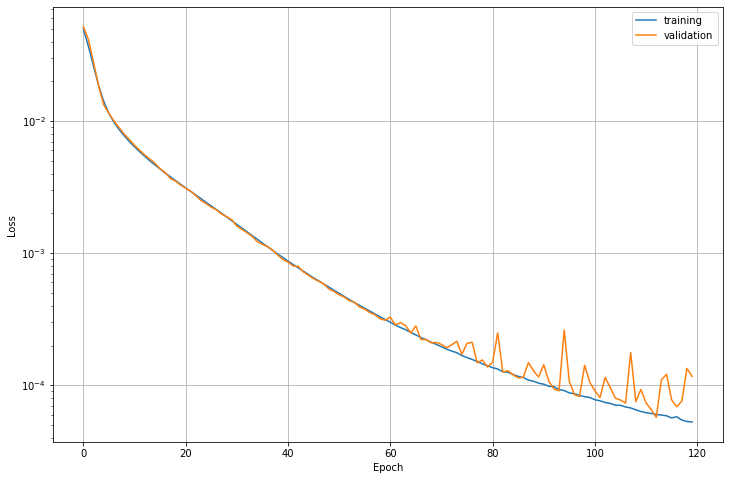

In [13]:
plt.figure(figsize=(12,8))
plt.plot(tot_train_loss, label="training")
plt.plot(tot_val_loss, label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

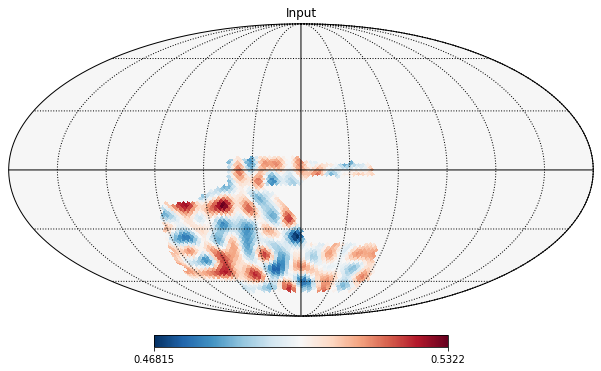

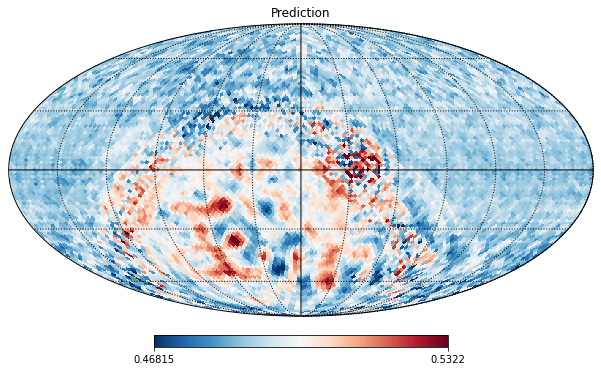

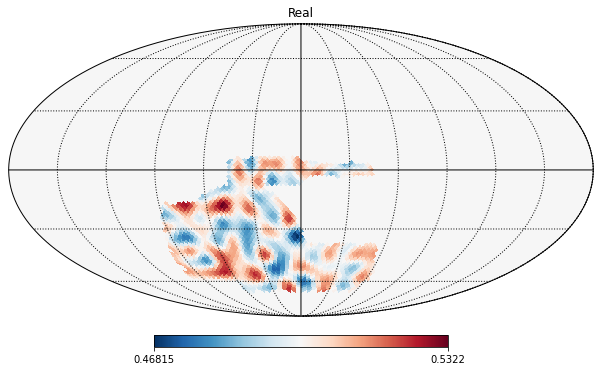

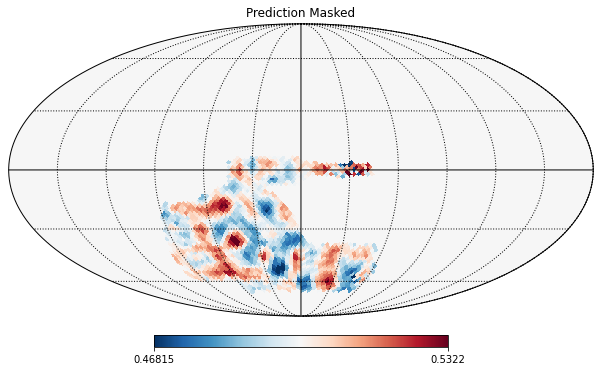

In [15]:
prediction = unet_model.predict(x[-1][None,...])

cm = plt.cm.RdBu_r

hp.mollview(x[-1].flatten(), title='Input', nest=True, cmap=cm, min=np.min(y[-1]), max=np.max(y[-1]))
hp.graticule()
hp.mollview(prediction[0].flatten(), title='Prediction', nest=True, cmap=cm, min=np.min(y[-1]), max=np.max(y[-1]))
hp.graticule()
hp.mollview(y[-1].flatten(), title='Real', nest=True, cmap=cm, min=np.min(y[-1]), max=np.max(y[-1]))
hp.graticule()

prediction = np.array([prediction[0].flatten()])
prediction = np.array([np.where(mask>0.5,x_i,mean) for x_i in prediction])

hp.mollview(prediction[0], title='Prediction Masked', nest=True, cmap=cm, min=np.min(y[-1]), max=np.max(y[-1]))
hp.graticule()
